<a href="https://colab.research.google.com/github/ziatdinovmax/GPim/blob/master/examples/notebooks/GP_2D3D_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gaussian processes for sparse 2D and 3D imaging

Prepared by Maxim Ziatdinov (March 2020)

E-mail: maxim.ziatdinov@ai4microscopy.com

---

This notebook applies Gaussian process regression for reconstructing sparse/corrupted 2D microscopy scans and 3D hperspectral data.

---



In [2]:
#@title Install/Import modules { form-width: "20%" }
# Install GPim
!python3 -m pip install -q gpim
# Imports
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import gpim
import torch
import warnings
warnings.filterwarnings("ignore", module="gpytorch.utils.interpolation")
# download training data
!wget -qq -O 'spiral_scans_2d.npy' 'https://github.com/ziatdinovmax/GPim/blob/master/expdata/spiral_s_00010_2019.npy?raw=true'
!wget -qq -O 'graphene_twist_2d.npy' 'https://github.com/ziatdinovmax/GPim/blob/master/expdata/graphene-twist-simulated.npy?raw=true'
!wget -qq -O 'sparse_hyper_3d.npy' 'https://github.com/ziatdinovmax/GPim/blob/master/expdata/bepfm_test_data.npy?raw=true'

     |████████████████████████████████| 286kB 11.8MB/s 
     |████████████████████████████████| 634kB 27.2MB/s 


Read and plot sparse 2D image data:

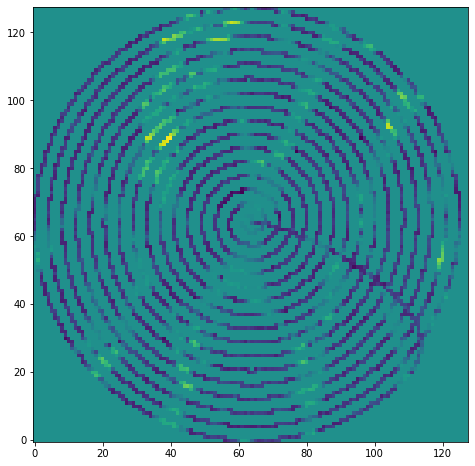

In [3]:
imgdata = np.load('spiral_scans_2d.npy')
plt.figure(figsize=(8, 8))
plt.imshow(imgdata, origin='bottom');

Normalize and assign NaNs to regions with no data:

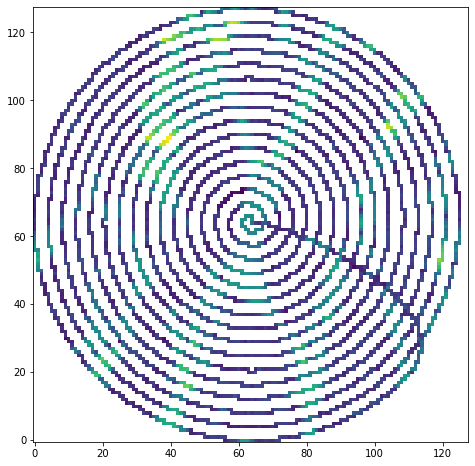

In [4]:
R = (imgdata - np.min(imgdata)) / np.ptp(imgdata)
R[R == R[1, 1]] = np.nan # Take value at [1, 1] as missing data value
plt.figure(figsize=(8, 8))
plt.imshow(R, origin='bottom');

Prepare data for GP regression. We are going to use a sparse grid ```X``` for model training and a full grid ```X_true``` for "testing"/prediction.

In [5]:
X_full = gpim.utils.get_full_grid(R) # get full grid indices
X_sparse = gpim.utils.get_sparse_grid(R) # get sparse grid indices

We will now run the GP regression for reconstructing the image from the sparse scan. Notice that by varying parameters such as ```indpoints```, ```learning_rate``` and ```iterations```, you can vary the model training time between seconds and minutes.

Model training...
average time per iteration: 0.052300000000000006 s
training completed in 15.2 s
Final parameter values:
 amp: 0.048, lengthscale: [3.8383 2.9884], noise: 0.0056217
Calculating predictive mean and variance... Done


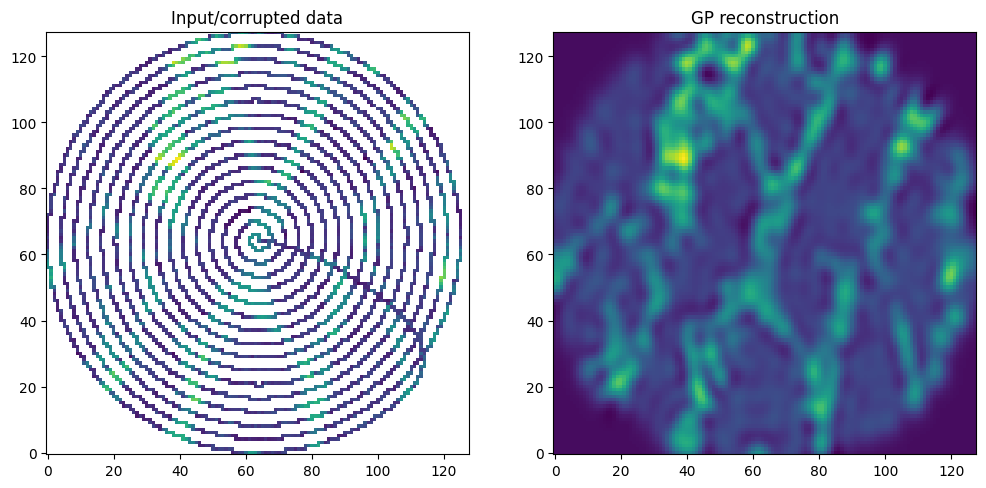

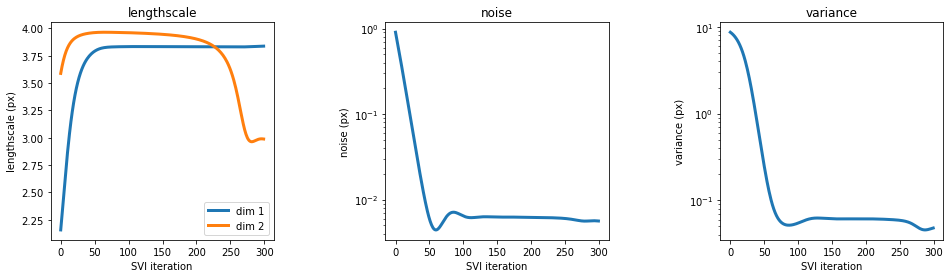

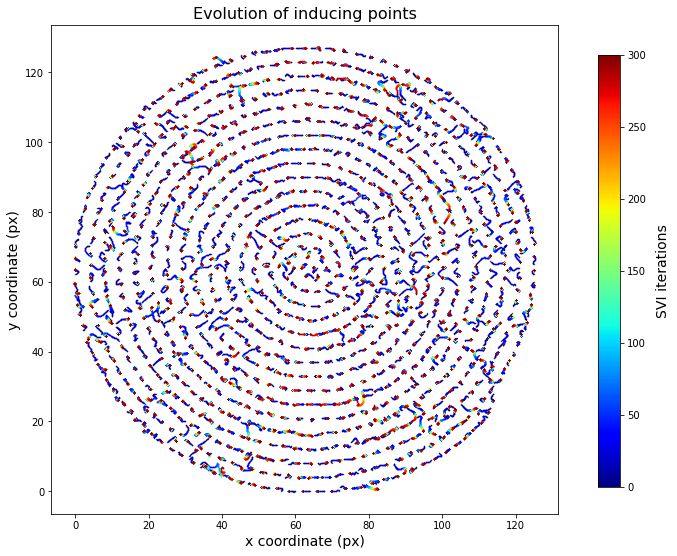

In [6]:
# type of kernel ('RBF', 'Matern52' or 'RationalQuadratic')
kernel = 'RBF'
# lengthscale constraints
lscale = [[1., 1.], [4., 4.]]
# Initiate and run GP reconstruction
reconstructor = gpim.reconstructor(
    X_sparse, R, X_full, # training input, training output, test input
    kernel, lengthscale=lscale, # GP kernel and lengthscale constraints
    sparse=True, indpoints=1000, # Run sparse GP with 1000 inducing points
    learning_rate=0.1, iterations=300, # learning rate and number of SVI steps
    use_gpu=True, verbose=1 # GPU acceleration and verbosisty
)
mean, sd, hyperparams = reconstructor.run()
# Plot results and evolution of kernel hyperparameters during training
gpim.utils.plot_reconstructed_data2d(R, mean, cmap='viridis')
gpim.utils.plot_kernel_hyperparams(hyperparams)
gpim.utils.plot_inducing_points(hyperparams)

We can also use [structured kernel](http://proceedings.mlr.press/v37/wilson15.pdf) GP approach, which generally allows fitting more "inducing points" into memory and can produce a higher quality reconstruction on larger datasets:

Model training...
average time per iteration: 0.13799999999999998 s
training completed in 22.96 s
Final parameter values:
 lengthscale: [1.9053 1.9245], noise: 0.0024837
Calculating predictive mean and uncertainty...
Batch 1/1
Done


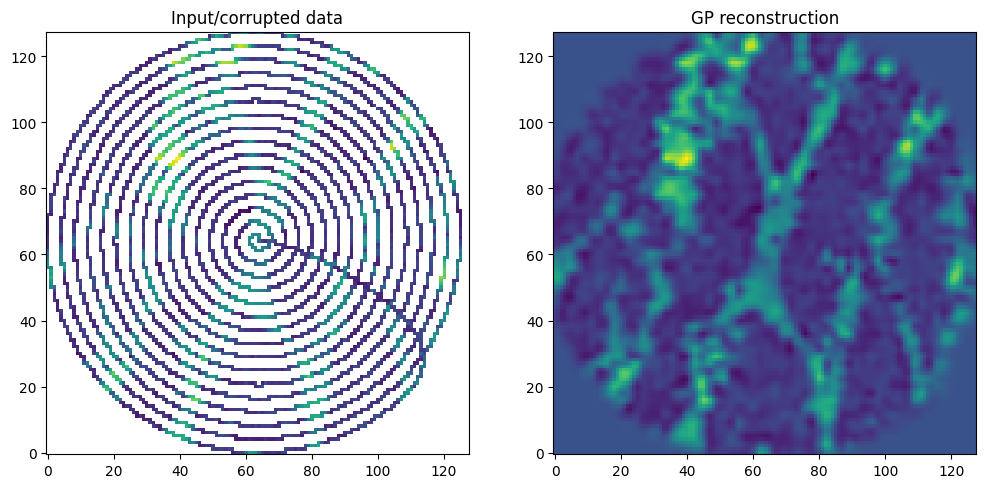

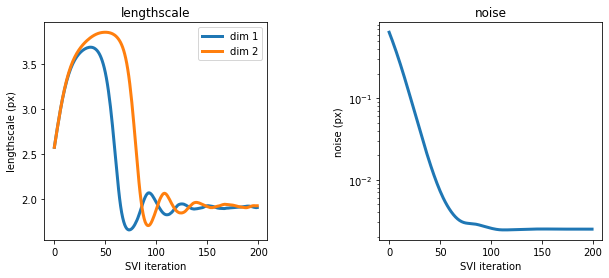

In [7]:
# Initiate and run GP reconstruction
skreconstructor = gpim.skreconstructor(
    X_sparse, R, X_full, 
    kernel, lengthscale=lscale,
    learning_rate=0.1, iterations=200,
    use_gpu=True, verbose=1
)
mean, sd, hyperparams = skreconstructor.run()
# Plot results and evolution of kernel hyperparameters during training
gpim.utils.plot_reconstructed_data2d(R, mean, cmap='viridis')
gpim.utils.plot_kernel_hyperparams(hyperparams)

## 3D sparse hyperspectral data

We next demonstratre how to apply GP to the reconstruction of sparse 3D hyperspectral dataset.

Load 3D dataset:

In [11]:
imgdata3d = np.load('sparse_hyper_3d.npy')
R_true = (imgdata3d - np.amin(imgdata3d))/np.ptp(imgdata3d)

Do some simple visualization:

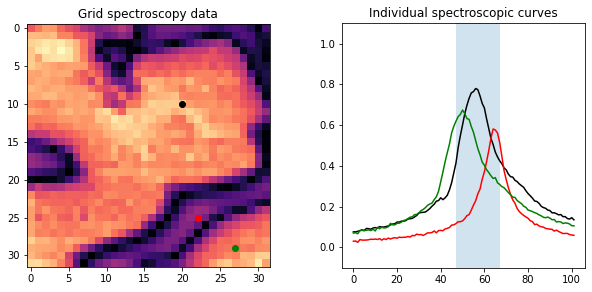

In [12]:
# choose slice
slice_number = 57
# size of window for averaging
spectral_window = 10
# select cooordinates for individual spectroscopic curves
pos = [
       [10, 20], 
       [25, 22], 
       [29, 27],
]
# plot
gpim.utils.plot_raw_data(R_true, slice_number, pos, spectral_window, norm=True)

We corrupt data by removing certain percentage of the observations (i.e. removing the entire spectroscopic curves from random xy locations):

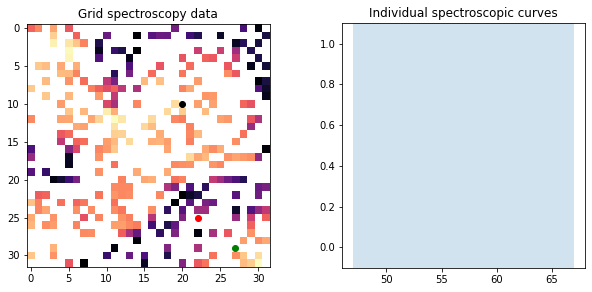

In [13]:
remove_obs = 0.7 # remove 70 % of the data

# Store "true" grid indices before removing parts of the data
X_true = gpim.utils.get_full_grid(R_true)
# Remove observations and plot the new "corrupted" data
X, R = gpim.utils.corrupt_data_xy(X_true, R_true, prob=remove_obs)
gpim.utils.plot_raw_data(R, slice_number, pos, spectral_window, norm=True)

We now run GP regression on the corrupted data to reconstruct the original signal:

(This may take some some on older GPUs such as Tesla K80)

In [14]:
lengthscale_ = [[1., 1., 1.], [20., 20., 20.]]

reconstr = gpim.reconstructor(
    X, R, X_true, kernel='Matern52', lengthscale=lengthscale_, 
    sparse=True, indpoints=1000, learning_rate=0.1, iterations=500, 
    use_gpu=True, verbose=2
)
mean, sd, hyperparams = reconstr.run()

# of inducing points for sparse GP regression: 1024
Model training...
iter: 0 ... loss: 56663.2848 ... amp: 8.6959 ... length: [ 8.3244 17.3963  3.7983] ... noise: 1.1051709 ...
iter: 100 ... loss: -44936.4832 ... amp: 0.3975 ... length: [12.576  19.549  16.6097] ... noise: 0.0027713 ...
average time per iteration: 0.19649999999999998 s
iter: 200 ... loss: -55292.1233 ... amp: 0.0116 ... length: [ 3.2128  4.937  18.4896] ... noise: 0.0011057 ...
iter: 300 ... loss: -55576.9876 ... amp: 0.0117 ... length: [ 3.1241  4.8429 18.5028] ... noise: 0.0010543 ...
iter: 400 ... loss: -55469.7086 ... amp: 0.0119 ... length: [ 3.1053  4.8339 18.492 ] ... noise: 0.0010601 ...
iter: 499 ... loss: -55437.8168 ... amp: 0.0118 ... length: [ 3.1019  4.7987 18.4735] ... noise: 0.0010628 ...
training completed in 97.23 s
Final parameter values:
 amp: 0.0118, lengthscale: [ 3.1019  4.7987 18.4735], noise: 0.0010628
Calculating predictive mean and variance... Done


Plot the evolution of hyperparameters during the training:

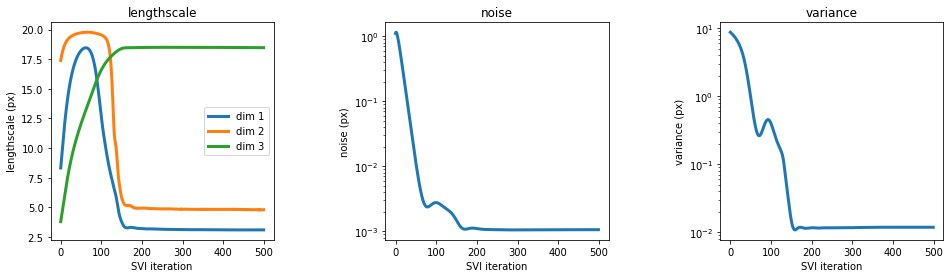

In [15]:
gpim.utils.plot_kernel_hyperparams(hyperparams)

Plot the evolution of inducing points:

(may take up to ~1 minute)

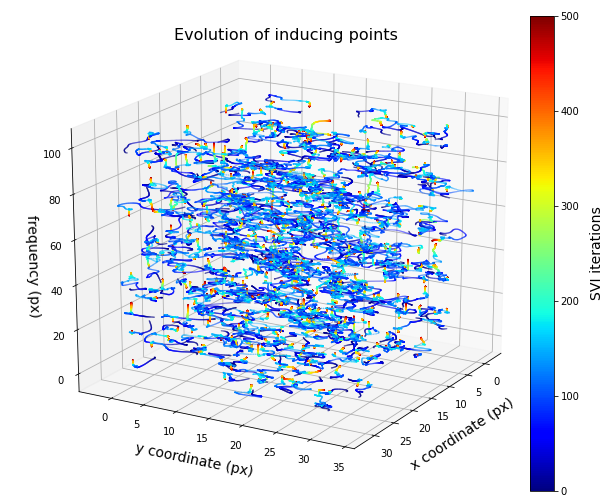

In [16]:
gpim.utils.plot_inducing_points(hyperparams, slice_step=2)

Plot the results:

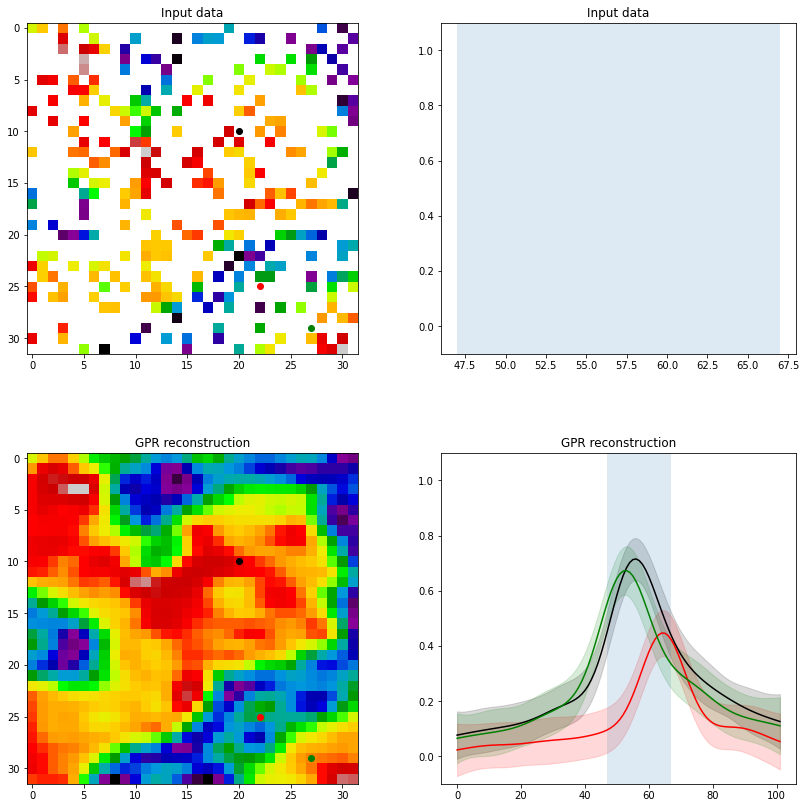

In [17]:
gpim.utils.plot_reconstructed_data3d(R, mean, sd, slice_number, pos, spectral_window)

Looks like even with ~70 % of observations removed we were able to reconstruct the original signal pretty accurately!